In [148]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor  # pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgbexcel import XGBtoExcel
from sklearn.linear_model import LinearRegression

In [87]:
!pip install xgbexcel

  Using cached xgbexcel-0.0.1-py3-none-any.whl (4.3 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Считывание данных

In [101]:
convert = lambda x: x if 0 < x > 150 else 0
convert = np.vectorize(convert)

Функция для нормализации предсказаний

Предсказаний меньше нуля никак не может быть, так что мы можем ограничить все предсказания

In [102]:
warnings.filterwarnings("ignore")

Отключение предупреждений от моделей

In [103]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

Установка рабочей директории (тк данные располагаются на 2 папки выше)

In [104]:
data = pd.read_excel("raw_data/Статистика для графиков 3 д (ТЭЦ-2) для предсказ..xlsx")

Считывание данных

# Предобработка данных

In [105]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [106]:
columns_for_predictions = [
    column
    for column in data.columns
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

Получаем все колонки, связанные с "Удельный расход условного топлива на отпуск э/э гр.130"

In [107]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130 ТЭЦ-2',
 'Отпуск тепла из ТО ТА гр.130 ТЭЦ-2',
 'Удельный расход условного топлива на отпуск э/э гр.130']

## Добавление фич даты

In [108]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

Разделяем значение даты на день/месяц/год

In [109]:
date = date[1:]

In [110]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [111]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [112]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [113]:
data = data.drop(["Дата"], axis=1)

In [114]:
data = data[columns_for_predictions + ["day", "month", "year"]]
# data = data[columns_for_predictions]

# Обработка выбросов

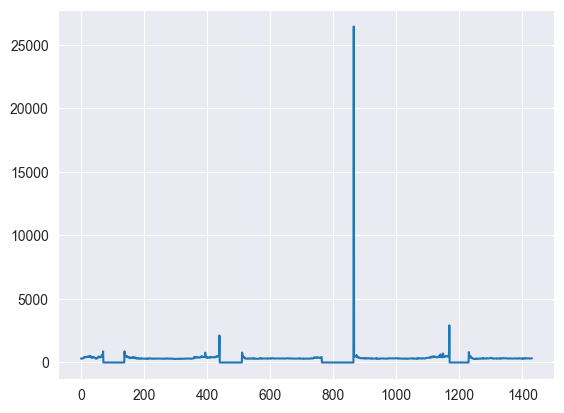

In [115]:
plt.plot(data[target]);

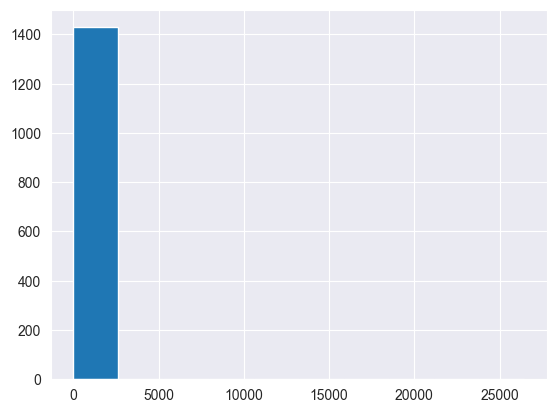

In [116]:
plt.hist(data[target]);

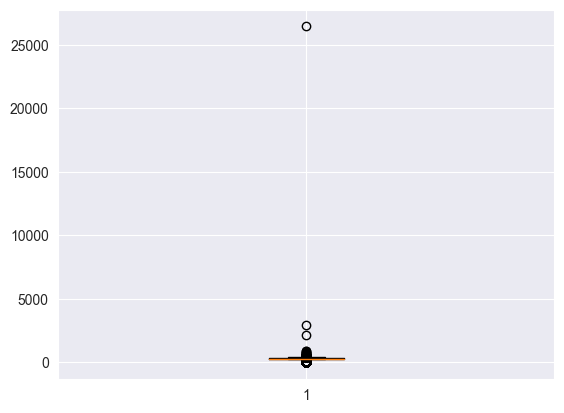

In [117]:
plt.boxplot(data[target]);

In [118]:
data = data.loc[data[target] < 2000]

Вообще, самым лучшим вариантом будет исключение выбросов через квантили, но тогда мы исключим нулевые значения и значения при пиковых нагрузках, а это может негативно сказаться на результате, одним из "хороших" решений было бы исключить значения выше 600

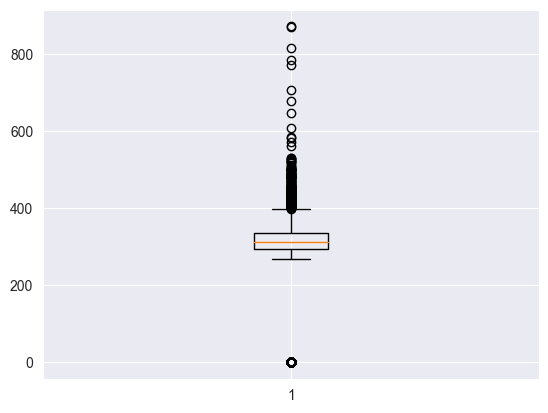

In [119]:
plt.boxplot(data[target]);

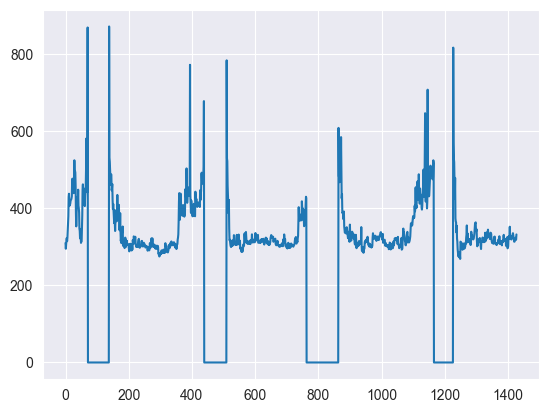

In [120]:
plt.plot(np.array(data[target]));

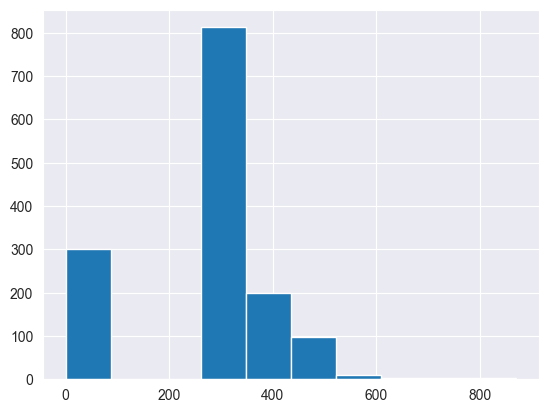

In [121]:
plt.hist(data[target]);

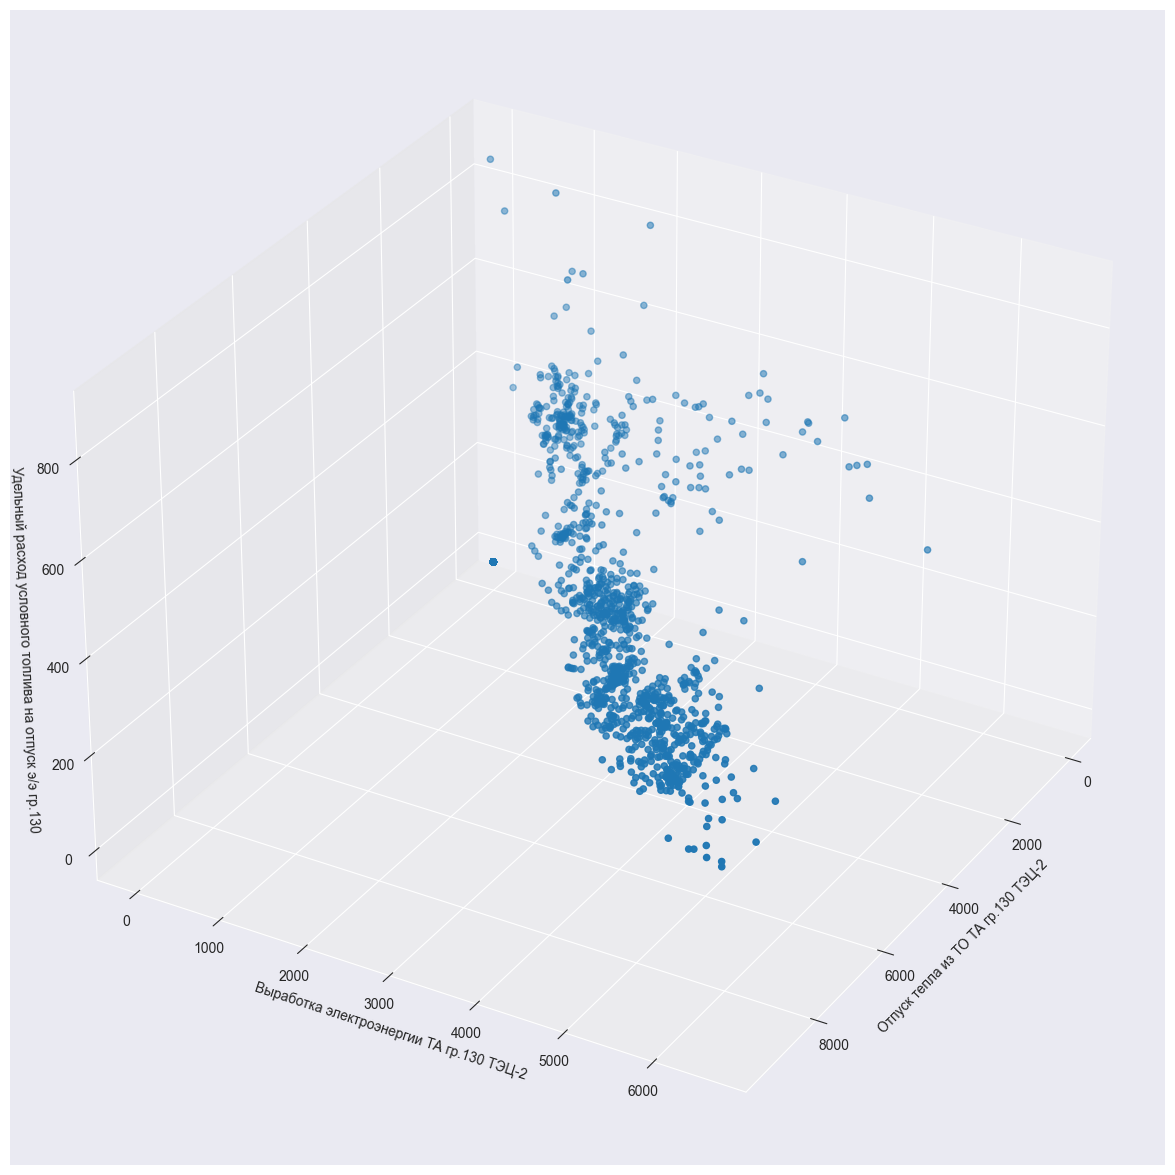

In [122]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
fig.set_figheight(15)
fig.set_figwidth(15)
ax.scatter(
    data[columns_for_predictions[1]],
    data[columns_for_predictions[0]],
    data[columns_for_predictions[2]]
)

ax.view_init(30, 30)
ax.set_xlabel(columns_for_predictions[1])
ax.set_ylabel(columns_for_predictions[0])
ax.set_zlabel(columns_for_predictions[2]);

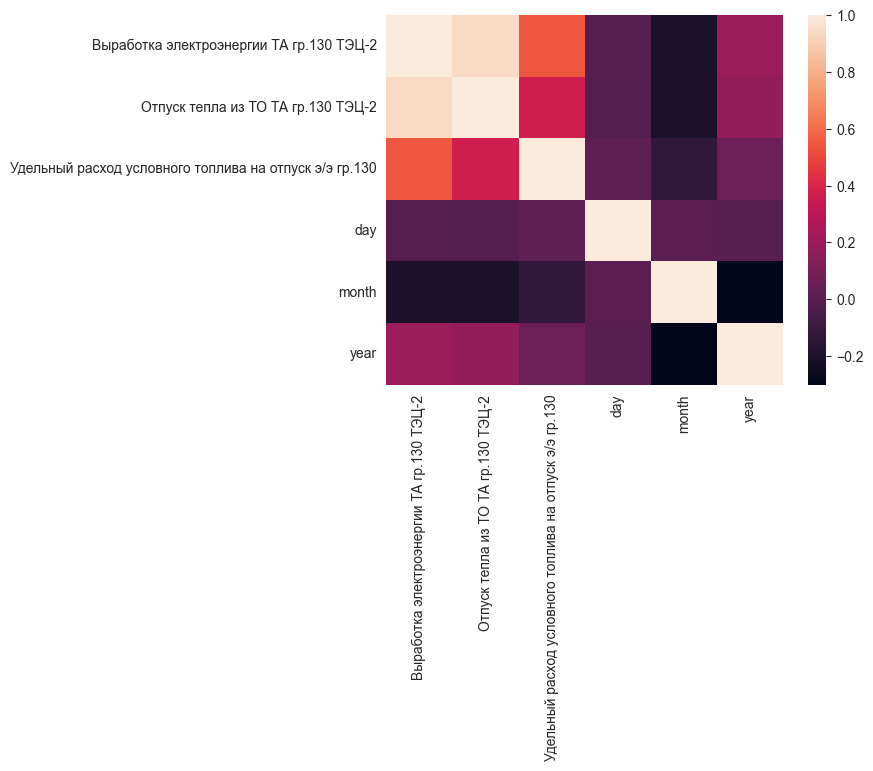

In [123]:
sns.heatmap(data.corr());

# Создание датасета для обучения
## Разделение данных

In [124]:
X = data.drop(target, axis=1)

In [125]:
y = data[target]

In [126]:
out_shape = 1

In [129]:
X_new = np.array([[0] * X.shape[1]])
y_new = np.array([[0] * out_shape])

## Создание датасета для предсказаний на 1 день

In [130]:
for i in range(len(data.drop(target, axis=1).values) - out_shape):
    concat_x_data = data.drop(
        target, axis=1
    ).iloc[i].values
    concat_y_data = np.stack(
        [
            data.iloc[i + 1][target],
            # data.iloc[i + 2][target],
            # data.iloc[i + 3][target],
            # data.drop(
            #     get_columns_without_tagrets(target), axis=1
            # ).iloc[i + 4][target]
        ]
    )

    X_new = np.append(X_new, [concat_x_data], axis=0)
    y_new = np.append(y_new, [concat_y_data], axis=0)

Мы берём текущее значение y с индексом i, записываем его в X, а значение y с индексом i+1 записываем в y

In [131]:
X_new = X_new[1:]
y_new = y_new[1:]

# Разделение на тренировочную и тестовую выборки

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

## Обучение и предсказания

In [133]:
model = XGBRegressor()

In [134]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [135]:
predictions = np.array(model.predict(X_new))

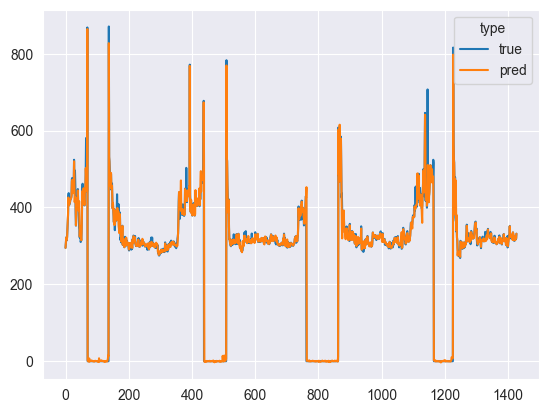

In [136]:
plt.plot(y_new, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [137]:
r2_score(y_new, predictions)

0.976522501465541

In [138]:
if not os.path.isdir("models"):
    os.mkdir("models")

In [139]:
XGBtoExcel(model).save_expr("models/xgb0.97.txt")

Saved!


In [149]:
linear_model = LinearRegression()

In [150]:
linear_model.fit(X_train, y_train)

LinearRegression()

In [151]:
predictions = np.array(linear_model.predict(X_new))

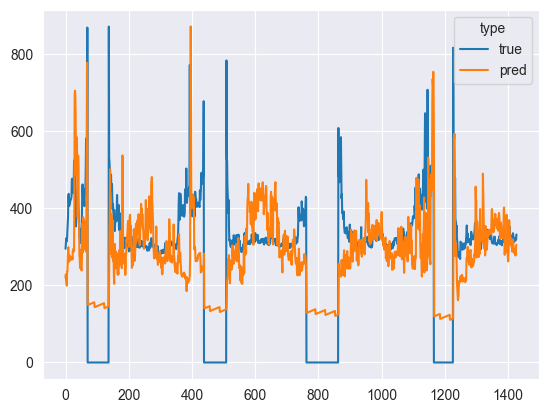

In [152]:
plt.plot(y_new, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [153]:
r2_score(y_new, predictions)

0.44224866504557947

In [155]:
linear_model.intercept_

array([20575.83294657])